# Data Assimilation for One-dimensional GW flow model
Data assimilation combines model predictions and observations. In this notebook, the model will be setup first and then it will be used to generate a set  of synthatic observations.

In [1]:
import time
start_time = time.time()
import os, sys
import numpy as np
import pandas as pd
import configparser
sys.path.insert(0, r"D:\Workspace\Codes\pyemu_myfork\pyemu")
import pyemu
import matplotlib.pyplot as plt
import inspect
import shutil
import flopy

## Config Parameters
In this exercise, we will use multiple user configuration parameters. To make things clean, we used the a configuration file to hold all these parameters.

In [2]:
config = configparser.ConfigParser()
config.read("config.init")
fidw = open("config.init", 'r')
settings = fidw.read()
fidw.close()
print(settings)

[workspace]
basename = flow1d
template_folder = flow1d_tmp
worker_folder =  flow1d_worker

[model_info]
input_files = input_dis.csv, hk_1.dat, iheads_1.dat
output_files = output_sim.csv

[da_settings]
vs_code_dir = D:\Workspace\projects\mississippi\pure_c_pestpp\pestpp
num_realizations = 50
ensemble_filename = heads_out.csv

[da_ensemble]
seed_number = 42
correlation_length = 50
number_of_realizations = 50






## Setup workspace
Create a template folder that will contain model executable, model input files, and model output files. It is 
called "template" because the worker will be generated from it.

In [3]:
template_ws = os.path.join(".", config.get('workspace', 'template_folder')) # od_flow os one dim flow model
if not(os.path.isdir(template_ws)):
    os.mkdir(template_ws)
else:
    shutil.rmtree(template_ws)
print(os.path.abspath(template_ws))

D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow_enkf\flow1d_tmp


# Model description
A Python function "generate_1d_model" is used to setup a 1D GW flow model as well as misc files that we will be used and shown in this notebook. The following are the main features in the model:- 
* The model consists of one layer, one row, and 100 columns. 
* The model generates a one-row model where a general head boundary (GHB = -10 m) exist at the upstream and another on GHB downstream (GHB = -20). We should interpret the negative number as depth below groundsurface level.
* The model consists of 24 stress periods, and each stress period has 30 time steps.
* Recharge is applied uniformly in space and variably in time at all cells. 
* In the middle cell a groundwater pumping is applied. 

Let us generate the model and look more at it's component. For detailed information about model setup, please see "generate_1d_model" in file model_setup. Let Look us at output at the end of the simulation.



In [4]:
def csv_to_tpl(csv_file, name_col, par_col, tpl_file ):
    df = pd.read_csv(csv_file)

    fidw = open(tpl_file, 'w')
    fidw.write("ptf ~\n")

    for i, col in enumerate(df.columns):
        if i == 0:
            csv_header = str(col)
            continue
        csv_header = csv_header + "," + str(col)
    csv_header = csv_header + "\n"
    fidw.write(csv_header)

    line = ""
    for irow, row in df.iterrows():
        row[par_col] =  " ~   {0}    ~".format(row[name_col])
        line = ",".join(row.astype(str).values.tolist()) + "\n"
        fidw.write(line)

    fidw.close()

def csv_to_ins(csv_file, name_col, obs_col, ins_file):
    df = pd.read_csv(csv_file)
    part1 = "l1"

    for col in df.columns:
        if col in [obs_col]:
            break
        part1 = part1 + " ~,~"

    obs_names = df[name_col]
    fidw = open(ins_file, 'w')
    fidw.write("pif ~\n")
    fidw.write("l1\n") # header

    for irow, row in df.iterrows():
        line = part1 + "   !{0}!    ~".format(row[name_col])
        line = line + ",~\n"

        fidw.write(line)

    fidw.close()


def generate_random_ensemble(dx = np.array([1]* 100),
                             dy = np.array([1])
                             , corr_scale = 10, N = 100 ):
    v = pyemu.utils.geostats.ExpVario(a=corr_scale,contribution=1.0)
    gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.0)

    ss = pyemu.utils.geostats.SpecSim2d(dx,dy,gs)
    arrays = ss.draw_arrays(num_reals=N)
    arrays = arrays.squeeze().T
    return arrays

FloPy is using the following  executable to run the model: D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\bin\win\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: flow_1d.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/06/09 22:32:54

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress

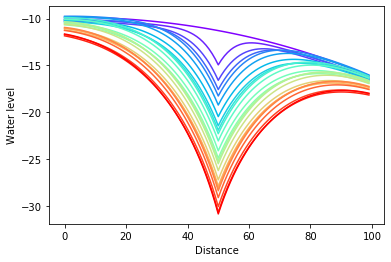

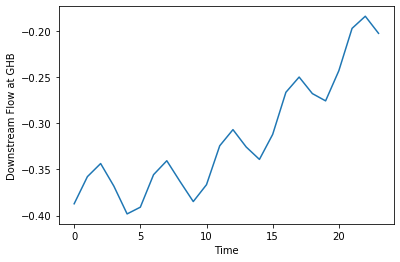

In [5]:
#2) create a simple flow model
from model_setup import generate_1d_model
figs = generate_1d_model() # this is a simple script that setup the 1D flow problem. 


The GW pumping causes a depression cone to develop and grow with time.

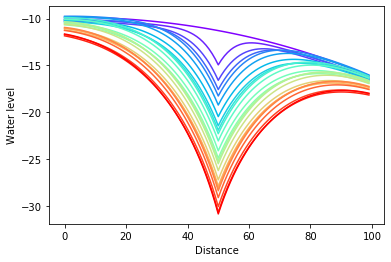

In [6]:
#%matplotlib inline
figs[0]

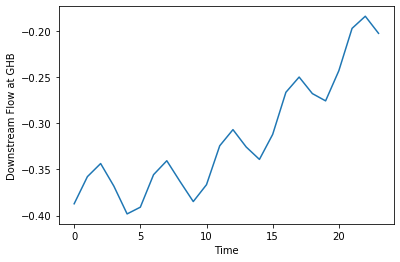

In [7]:
figs[1]

In [8]:
# Copy the generated model to the template folder
print(os.listdir())
shutil.copytree('model_dataset', os.path.join(template_ws, 'model_dataset'))
shutil.rmtree('model_dataset')
shutil.copy('..\param_utils.py', os.path.join(template_ws, 'param_utils.py'))
shutil.copy('..\obs_utils.py', os.path.join(template_ws, 'obs_utils.py'))

['.ipynb_checkpoints', 'config.init', 'da_transit.ipynb', 'flow1d.insfile_data.csv', 'flow1d.obs_data.csv', 'flow1d.pargp_data.csv', 'flow1d.par_data.csv', 'flow1d.tplfile_data.csv', 'misc_files', 'model_dataset', 'model_setup.py', 'one_dim_flow.ipynb', 'one_dim_flow.py', 'one_dim_flow2.py', 'PstFrom.log', 'xxxx_tobe_remove_forward_model.py', '__pycache__']


'.\\flow1d_tmp\\obs_utils.py'

### Simplifying Model I/O
We write a Python warapper that takes one file for each parameter group and generate one output file as output. Let us look at the model input files. Output file is similar to observation data section. This is just a personal preference! you may still deals with the native MODFLOW I/O files.
* input_dis.csv
* hk_1.dat
* iheads_1.dat

The model script (model_setup.py) has a function called "forward_model" that will work as our model.

In [10]:
import model_setup
src_forward_run = inspect.getsource(model_setup.forward_run)
print(src_forward_run)

def forward_run():
    modelname = "flow_1d"
    model_ws = r"model_dataset"

    # always start by removing old output files
    try:
        os.remove(os.path.join(model_ws, "output_sim.csv"))
    except:
        pass

    input_dis = pd.read_csv(os.path.join(model_ws, "input_dis.csv"))
    temporal_df = pd.read_csv(os.path.join(model_ws, "temporal_param.csv"))

    mf = flopy.modflow.Modflow.load(f=modelname + ".nam", model_ws=model_ws)

    # ------ update dis
    start_sp = input_dis.loc[input_dis['parname'] ==  'start_sp', 'parval'].values[0]
    end_sp = input_dis.loc[input_dis['parname'] ==  'end_sp', 'parval'].values[0]
    nlay = mf.dis.nlay
    nrow = mf.dis.nrow
    ncol = mf.dis.ncol
    delr = mf.dis.delr.array
    delc = mf.dis.delc.array
    ztop = mf.dis.top.array
    botm = mf.dis.botm.array

    time_mask = (temporal_df['stress_period'] >= start_sp) & \
                (temporal_df['stress_period'] <= end_sp)
    curr_tempora_df = temporal_df[time_mask]
    curr_sps 

In [11]:
# let us assemble the script that works as forward_model
script = """
import os, sys
import shutil
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import pyemu
import obs_utils, param_utils

{}
if __name__ == "__main__":
     forward_run()
 
""".format(src_forward_run)
print(script)


import os, sys
import shutil
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import pyemu
import obs_utils, param_utils

def forward_run():
    modelname = "flow_1d"
    model_ws = r"model_dataset"

    # always start by removing old output files
    try:
        os.remove(os.path.join(model_ws, "output_sim.csv"))
    except:
        pass

    input_dis = pd.read_csv(os.path.join(model_ws, "input_dis.csv"))
    temporal_df = pd.read_csv(os.path.join(model_ws, "temporal_param.csv"))

    mf = flopy.modflow.Modflow.load(f=modelname + ".nam", model_ws=model_ws)

    # ------ update dis
    start_sp = input_dis.loc[input_dis['parname'] ==  'start_sp', 'parval'].values[0]
    end_sp = input_dis.loc[input_dis['parname'] ==  'end_sp', 'parval'].values[0]
    nlay = mf.dis.nlay
    nrow = mf.dis.nrow
    ncol = mf.dis.ncol
    delr = mf.dis.delr.array
    delc = mf.dis.delc.array
    ztop = mf.dis.top.array
    botm = mf.dis.botm.array

    time_mask = (tem

In [12]:
# Let us write the model
with open(os.path.join(template_ws, r"forward_model.py"), 'w') as fidw:
    fidw.write(script)

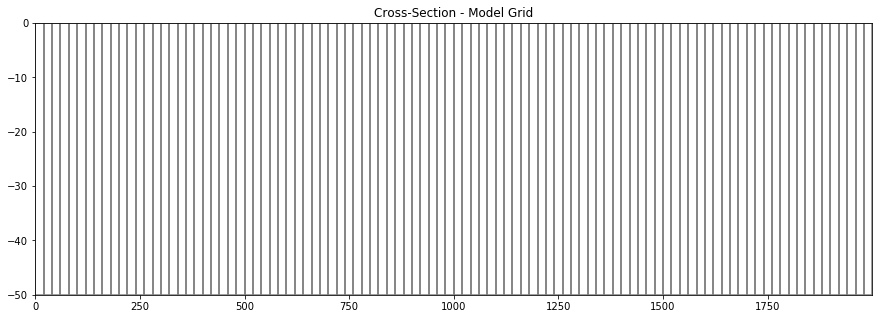

In [13]:
fnam = os.path.join(template_ws, r'model_dataset\flow_1d.nam')
mf = flopy.modflow.Modflow.load(os.path.basename(fnam), model_ws= os.path.dirname(fnam))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
linecollection = xsect.plot_grid()
t = ax.set_title('Cross-Section - Model Grid')

## Problem dimensions

In [14]:

np.random.seed(int(config.get('da_ensemble', 'seed_number' )))               
corr_scale = 20.0*float(config.get('da_ensemble', 'correlation_length' ))
nx, ny = mf.nrow, mf.ncol # of cells
N = int(config.get('da_ensemble', 'number_of_realizations' )) # number of realizations
#m = int(config.get('da_ensemble', 'number_of_realizations' ) # number of measurements
refence_realization = 4
delc = mf.dis.delc.array * 20 # cells must be square to use geostat simulator!
delr = mf.dis.delr.array



Let us run the model and look at output file

In [15]:
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

In [16]:
out_df = pd.read_csv(os.path.join(template_ws, r".\model_dataset\output_sim.csv" ))
out_df

,obsnme,simval,obsval,weight,obgnme,comments
0,hf_0_0_0,-11.650773,0.0,1.0,simH,#
1,hf_0_0_1,-11.712117,0.0,1.0,simH,#
2,hf_0_0_2,-11.780944,0.0,1.0,simH,#
3,hf_0_0_3,-11.857170,0.0,1.0,simH,#
4,hf_0_0_4,-11.940759,0.0,1.0,simH,#
...,...,...,...,...,...,...
311,qghb_600,-0.275922,0.0,1.0,ghbQ,#
312,qghb_630,-0.243325,0.0,1.0,ghbQ,#
313,qghb_660,-0.197502,0.0,1.0,ghbQ,#
314,qghb_690,-0.184379,0.0,1.0,ghbQ,#


In sequential Data Assimilation, we need to be able to rerun the model starting from any arbitrary time point and stop at any other time point . The Python wrapper, that works as our model, uses a simple csv input file with two parameters: start time and end time. In this example we are going to divide the 24 stress periods into 4 cycles. 

In [17]:
# We can change the start time and end time and run the model. Since our model has 24 stress period,
# let us divide it into 4 cycles, each has 6 stress period
df_input = pd.read_csv(os.path.join(template_ws, r"model_dataset\input_dis.csv" ))
df_input.loc[df_input['parname']=='start_sp', 'parval'] = 0
df_input.loc[df_input['parname']=='end_sp', 'parval'] = 5
df_input.to_csv(os.path.join(template_ws, r"model_dataset\input_dis.csv" ))
df_input

,parname,parval
0,start_sp,0
1,end_sp,5


Additionally, we have a master file that holds all transient information that define what pumping (Qw), recharge (Rch), and reference heads at boundary conditions, that are used. In MODFLOW, we also we need to define the stress period length and number of time steps in each stress period. In a more complex model setup, we might need to define a file groundwater pumping; in this case this csv file might contain a pumping file name for each stress period.  

In [18]:
trans_data = pd.read_csv(os.path.join(template_ws, r".\model_dataset\temporal_param.csv" ))
trans_data

,stress_period,perlen,nstp,GHB_UP,GHB_DN,Qw,Rch
0,0,30.0,30,-10.0,-20.0,0.0,0.000200
1,1,30.0,30,-10.0,-20.0,-3.5,-0.001717
2,2,30.0,30,-10.0,-20.0,-3.5,-0.000891
3,3,30.0,30,-10.0,-20.0,-3.5,0.001496
4,4,30.0,30,-10.0,-20.0,-3.5,0.002029
5,5,30.0,30,-10.0,-20.0,-3.5,-0.000056
6,6,30.0,30,-10.0,-20.0,-3.5,-0.001774
7,7,30.0,30,-10.0,-20.0,-3.5,-0.000668
8,8,30.0,30,-10.0,-20.0,-3.5,0.001681
9,9,30.0,30,-10.0,-20.0,-3.5,0.001910


In [19]:
# now let us run the model using the new start and end times
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

In [20]:
out_df = pd.read_csv(os.path.join(template_ws, r".\model_dataset\output_sim.csv" ))
out_df

,obsnme,simval,obsval,weight,obgnme,comments
0,hf_0_0_0,-9.835374,0.0,1.0,simH,#
1,hf_0_0_1,-9.832211,0.0,1.0,simH,#
2,hf_0_0_2,-9.831079,0.0,1.0,simH,#
3,hf_0_0_3,-9.832043,0.0,1.0,simH,#
4,hf_0_0_4,-9.835171,0.0,1.0,simH,#
...,...,...,...,...,...,...
149,qghb_60,-0.357905,0.0,1.0,ghbQ,#
150,qghb_90,-0.343728,0.0,1.0,ghbQ,#
151,qghb_120,-0.368163,0.0,1.0,ghbQ,#
152,qghb_150,-0.398217,0.0,1.0,ghbQ,#


## Setup the PEST files
### Input/Template files 
We have three files..

In [21]:
# ---------------------------
#(1) input_dis.csv File
# ---------------------------
input_file_list = [] # a container for all pst files input/output and tpl/ins file
tpl_file_list = []
parnames = []
obsnames = []

par_fn = os.path.join(template_ws,r"model_dataset\input_dis.csv")
df_par1 = pd.read_csv(par_fn)

# add the file to pst files container
input_file_list.append(r"model_dataset\input_dis.csv")
tpl_file_list.append(r"model_dataset\input_dis.csv"+".tpl")

#generate template file by converting csv file into simple tpl file
csv_to_tpl(csv_file=par_fn, par_col='parval', name_col='parname', tpl_file= par_fn+".tpl")

# we will keep adding params to this list
parnames = parnames + df_par1['parname'].values.tolist()

# see the template file
f = open(par_fn+".tpl", 'r')
print(f.read())
f.close()


ptf ~
Unnamed: 0,parname,parval
0,start_sp, ~   start_sp    ~
1,end_sp, ~   end_sp    ~



In [22]:
# ---------------------------
#(2) hk.dat File: the hydraulic conductivity field
# ---------------------------
par_fn =  os.path.join(template_ws,r"model_dataset\hk.dat")
arr = np.loadtxt(par_fn)

nms = ["k_{}".format(i) for i in range(len(arr))]

#simple temple
pyemu.utils.simple_tpl_from_pars(parnames=nms, tplfilename=par_fn + ".tpl")

# add the file to pst files container
input_file_list.append(r"model_dataset\hk.dat")
tpl_file_list.append(r"model_dataset\hk.dat"+".tpl")

# we will keep adding params to this list
parnames = parnames + nms

f = open(par_fn+".tpl", 'r')
print(f.read())
f.close()

ptf ~
~    k_0     ~
~    k_1     ~
~    k_2     ~
~    k_3     ~
~    k_4     ~
~    k_5     ~
~    k_6     ~
~    k_7     ~
~    k_8     ~
~    k_9     ~
~    k_10    ~
~    k_11    ~
~    k_12    ~
~    k_13    ~
~    k_14    ~
~    k_15    ~
~    k_16    ~
~    k_17    ~
~    k_18    ~
~    k_19    ~
~    k_20    ~
~    k_21    ~
~    k_22    ~
~    k_23    ~
~    k_24    ~
~    k_25    ~
~    k_26    ~
~    k_27    ~
~    k_28    ~
~    k_29    ~
~    k_30    ~
~    k_31    ~
~    k_32    ~
~    k_33    ~
~    k_34    ~
~    k_35    ~
~    k_36    ~
~    k_37    ~
~    k_38    ~
~    k_39    ~
~    k_40    ~
~    k_41    ~
~    k_42    ~
~    k_43    ~
~    k_44    ~
~    k_45    ~
~    k_46    ~
~    k_47    ~
~    k_48    ~
~    k_49    ~
~    k_50    ~
~    k_51    ~
~    k_52    ~
~    k_53    ~
~    k_54    ~
~    k_55    ~
~    k_56    ~
~    k_57    ~
~    k_58    ~
~    k_59    ~
~    k_60    ~
~    k_61    ~
~    k_62    ~
~    k_63    ~
~    k_64    ~
~    k_65    ~
~   

In [23]:
# ---------------------------
#(3) iheads.dat File: the initial hydraulic head field
# ---------------------------
par_fn =  os.path.join(template_ws,r"model_dataset\iheads.dat")
arr = np.loadtxt(par_fn)

nms = ["h_ini_{}".format(i) for i in range(len(arr))]
pyemu.utils.simple_tpl_from_pars(parnames=nms, tplfilename=par_fn + ".tpl")

# add the file to pst files container
input_file_list.append(r"model_dataset\iheads.dat")
tpl_file_list.append(r"model_dataset\iheads.dat"+".tpl")

# we will keep adding params to this list
parnames = parnames + nms

f = open(par_fn+".tpl", 'r')
print(f.read())
f.close()

ptf ~
~  h_ini_0   ~
~  h_ini_1   ~
~  h_ini_2   ~
~  h_ini_3   ~
~  h_ini_4   ~
~  h_ini_5   ~
~  h_ini_6   ~
~  h_ini_7   ~
~  h_ini_8   ~
~  h_ini_9   ~
~  h_ini_10  ~
~  h_ini_11  ~
~  h_ini_12  ~
~  h_ini_13  ~
~  h_ini_14  ~
~  h_ini_15  ~
~  h_ini_16  ~
~  h_ini_17  ~
~  h_ini_18  ~
~  h_ini_19  ~
~  h_ini_20  ~
~  h_ini_21  ~
~  h_ini_22  ~
~  h_ini_23  ~
~  h_ini_24  ~
~  h_ini_25  ~
~  h_ini_26  ~
~  h_ini_27  ~
~  h_ini_28  ~
~  h_ini_29  ~
~  h_ini_30  ~
~  h_ini_31  ~
~  h_ini_32  ~
~  h_ini_33  ~
~  h_ini_34  ~
~  h_ini_35  ~
~  h_ini_36  ~
~  h_ini_37  ~
~  h_ini_38  ~
~  h_ini_39  ~
~  h_ini_40  ~
~  h_ini_41  ~
~  h_ini_42  ~
~  h_ini_43  ~
~  h_ini_44  ~
~  h_ini_45  ~
~  h_ini_46  ~
~  h_ini_47  ~
~  h_ini_48  ~
~  h_ini_49  ~
~  h_ini_50  ~
~  h_ini_51  ~
~  h_ini_52  ~
~  h_ini_53  ~
~  h_ini_54  ~
~  h_ini_55  ~
~  h_ini_56  ~
~  h_ini_57  ~
~  h_ini_58  ~
~  h_ini_59  ~
~  h_ini_60  ~
~  h_ini_61  ~
~  h_ini_62  ~
~  h_ini_63  ~
~  h_ini_64  ~
~  h_ini_65  ~
~  h

### output/instruction files 

In [28]:
output_file_list = [] # a container for all pst files input/output and tpl/ins file
ins_file_list = []
output_file = r".\model_dataset\output_sim.csv"

fn_out = os.path.join(template_ws, output_file)
df_out = pd.read_csv(fn_out)
ins_file =  fn_out + ".ins"

# add the file to pst files container
output_file_list.append(r".\model_dataset\output_sim.dat")
ins_file_list.append(r".\model_dataset\output_sim.dat" + ".ins")

obsnames = df_out['obsnme'].values
pyemu.utils.simple_ins_from_obs(obsnames=obsnames, insfilename= os.path.join(template_ws, r".\model_dataset\output_sim.dat") + ".ins")
#csv_to_ins(csv_file = fn_out, name_col = 'obsnme', obs_col = 'simval',
#           ins_file = ins_file)




## Generate prior parameters/states ensemble
Notice that we have three input files, but only two has adjustable parameters/states: hk.dat and iheads.dat. The file input_dis.csv has data that only needed to restart the model. All adjustable states/parameters need prior ensembles

In [29]:
# (1) Prior K ensemble
pe_k = generate_random_ensemble(dx = np.array([1]* 100),
                             dy = np.array([1])
                             , corr_scale = 20, N = 50 )
print(pe_k)

SpecSim.initialize() summary: full_delx X full_dely: 228 X 228
[[ 0.78610933  0.31175315  1.77896875 ...  1.3268314  -1.04546187
  -1.10029038]
 [ 0.88375271 -0.14768947  2.33210411 ...  1.09956681 -1.49006741
  -1.28734845]
 [ 0.96581506  0.02622625  2.03940654 ...  1.53971305 -1.02899522
  -0.98207347]
 ...
 [ 1.57776724 -0.70355501  4.63768523 ...  0.26321416  1.2874001
   0.87874341]
 [ 1.52133792 -0.68850644  4.75207015 ...  0.53265212  1.47729041
   0.66555555]
 [ 0.9208281  -0.17321289  4.42199876 ... -0.4018023   0.96127021
   0.44263781]]


In [30]:
# (2) Prior initial head ensemble is assumed here the same. 
ihead = np.loadtxt(os.path.join(template_ws, "model_dataset\iheads.dat"))
pe_h = np.zeros_like(pe_k) + ihead[:,np.newaxis]
print(pe_h)

[[ -9.87246895  -9.87246895  -9.87246895 ...  -9.87246895  -9.87246895
   -9.87246895]
 [ -9.86974335  -9.86974335  -9.86974335 ...  -9.86974335  -9.86974335
   -9.86974335]
 [ -9.86826229  -9.86826229  -9.86826229 ...  -9.86826229  -9.86826229
   -9.86826229]
 ...
 [-15.84787846 -15.84787846 -15.84787846 ... -15.84787846 -15.84787846
  -15.84787846]
 [-15.98668575 -15.98668575 -15.98668575 ... -15.98668575 -15.98668575
  -15.98668575]
 [-16.12753105 -16.12753105 -16.12753105 ... -16.12753105 -16.12753105
  -16.12753105]]


In [31]:
# (3) The augmented forecast matrix can be assembled now...
pe = np.vstack([pe_k, pe_h])

nms1 = ["k_{}".format(i) for i in range(100)]
nms2 = ["h_ini_{}".format(i) for i in range(100)]

pe = pd.DataFrame(pe.T, columns=nms1+nms2)
pe.to_csv(os.path.join(template_ws, 'HKensemble.csv'))
x_true = pe.iloc[refence_realization].values

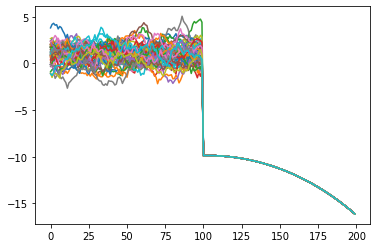

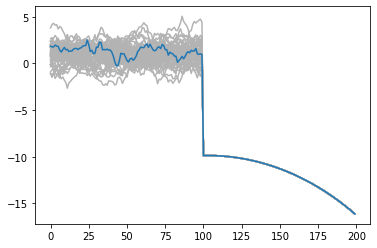

In [32]:
# (4) Before moving on, let us look visualize the prior ensemble
plt.figure()
plt.plot(pe.T.values)
plt.show()

ens =  pe.values.T
y_ref = ens[:, refence_realization]

plt.figure()
plt.plot(ens, color = [0.7,0.7,0.7], zorder=1)
plt.plot(ens[:,refence_realization])
plt.show()

# Observations
As mesnioned before, DA combine model with observations. This is just a synthatic problem, so we need to generate synthatic observations. The observation is generated by simulating a truth parameters (reference realization), which is a a user defined in the init file.

Let us run the model using the assumed synthatic reality and produce our measurements...

In [33]:
true_parameters = ens[:,refence_realization]

# (1) We need observations at the 24 stress periods.
df_input = pd.read_csv(os.path.join(template_ws, r"model_dataset\input_dis.csv" ))
df_input.loc[df_input['parname']=='start_sp', 'parval'] = 0
df_input.loc[df_input['parname']=='end_sp', 'parval'] = 23
df_input.to_csv(os.path.join(template_ws, r"model_dataset\input_dis.csv" ))

# (2) write input file using true K parameters. 
hk = true_parameters[0:100] # notice our model take the log as input
np.savetxt(os.path.join(template_ws, "model_dataset\hk.dat"), hk )

# (3) run the model
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)
df_truth_outupt = pd.read_csv(os.path.join(template_ws, "model_dataset\output_sim.csv"))


In [34]:
df_truth_outupt

,obsnme,simval,obsval,weight,obgnme,comments
0,hf_0_0_0,-15.658912,0.0,1.0,simH,#
1,hf_0_0_1,-15.664164,0.0,1.0,simH,#
2,hf_0_0_2,-15.670235,0.0,1.0,simH,#
3,hf_0_0_3,-15.675396,0.0,1.0,simH,#
4,hf_0_0_4,-15.680184,0.0,1.0,simH,#
...,...,...,...,...,...,...
311,qghb_600,-0.164446,0.0,1.0,ghbQ,#
312,qghb_630,-0.122799,0.0,1.0,ghbQ,#
313,qghb_660,-0.066254,0.0,1.0,ghbQ,#
314,qghb_690,-0.043727,0.0,1.0,ghbQ,#


In [35]:
# (4) Assign each observation to a cycle number. In this case study we divide the 24 stress periods into 4 cycles, each has 6 stress periods.
actual_obs_for_cycles = df_truth_outupt[df_truth_outupt['obgnme']=='simHO'].copy()
actual_obs_for_cycles["totim"] = actual_obs_for_cycles['obsnme'].str.split("_").str[-1].astype(int)
totims = np.sort(actual_obs_for_cycles["totim"].unique())
totims = totims.reshape(4,6)
for cycle in range(4):
    ttims = totims[cycle]
    actual_obs_for_cycles.loc[actual_obs_for_cycles['totim'].isin(ttims), 'cycle'] = cycle
actual_obs_for_cycles

,obsnme,simval,obsval,weight,obgnme,comments,totim,cycle
100,ho_10_30,-10.163459,0.0,1.0,simHO,#,30,0.0
101,ho_20_30,-10.198661,0.0,1.0,simHO,#,30,0.0
102,ho_30_30,-10.253308,0.0,1.0,simHO,#,30,0.0
103,ho_40_30,-10.306739,0.0,1.0,simHO,#,30,0.0
104,ho_50_30,-11.651049,0.0,1.0,simHO,#,30,0.0
...,...,...,...,...,...,...,...,...
287,ho_40_720,-16.471325,0.0,1.0,simHO,#,720,3.0
288,ho_50_720,-22.981693,0.0,1.0,simHO,#,720,3.0
289,ho_60_720,-20.480925,0.0,1.0,simHO,#,720,3.0
290,ho_70_720,-20.338072,0.0,1.0,simHO,#,720,3.0


## Cycle tables
At each cycle we need to define the observations to be assimilated, theirs weights, and non-adjustable parameters to used that are needed to restart the model to simulate each cycle. Cycle tables are a nice option to so


In [36]:
obsnames1 = actual_obs_for_cycles[actual_obs_for_cycles['cycle']==0]['obsnme'].values

obs_cycle = pd.DataFrame(index = obsnames1, columns = range(0,4))
weight_cycle = pd.DataFrame(index = obsnames1, columns = range(0,4))
par_cycle = pd.DataFrame(index = ['start_sp', 'end_sp' ], columns = range(0,4))
sp_strt = 0
sp_end = 5
for cycle in range(4):
    vals = actual_obs_for_cycles[actual_obs_for_cycles['cycle'] == cycle]['simval'].values
    obs_cycle[cycle] = vals
    weight_cycle[cycle] = 1000.0
    par_cycle[cycle] = [sp_strt, sp_end]
    sp_strt = sp_end + 1
    sp_end = sp_strt + 5
    
obs_cycle.to_csv(os.path.join(template_ws, 'head_obs_cycle.csv'))
weight_cycle.to_csv(os.path.join(template_ws, 'head_weight_cycle.csv'))
par_cycle.to_csv(os.path.join(template_ws, 'par_dis_cycle.csv'))

# PESTPP-DA Control Files

In [37]:
## (1) Generate PESTPP-DA control files files
pst = pyemu.Pst.from_par_obs_names(par_names= parnames,
                                   obs_names= obsnames)


In [38]:
# let us take a look at the observation data in PST
pst.observation_data

,obsnme,obsval,weight,obgnme
hf_0_0_0,hf_0_0_0,1.000000e+10,1.0,obgnme
hf_0_0_1,hf_0_0_1,1.000000e+10,1.0,obgnme
hf_0_0_10,hf_0_0_10,1.000000e+10,1.0,obgnme
hf_0_0_11,hf_0_0_11,1.000000e+10,1.0,obgnme
hf_0_0_12,hf_0_0_12,1.000000e+10,1.0,obgnme
...,...,...,...,...
qghb_150,qghb_150,1.000000e+10,1.0,obgnme
qghb_180,qghb_180,1.000000e+10,1.0,obgnme
qghb_30,qghb_30,1.000000e+10,1.0,obgnme
qghb_60,qghb_60,1.000000e+10,1.0,obgnme


In [39]:
# (2) All observation was assigned to one observation group. Let us fix that. Also let us assign all observations weight to 1000 for now. 
pst.observation_data['obsval'] = 0.0 # let put 0.0 here because observation will be read each cycle from the cycle table
pst.observation_data['weight'] = 1000 # this is 1/std
pst.observation_data['cycle'] = -1   # this means that observation will be used at all cycles

# why are we having three observation groups? do not we have one observation group, which is the head. Yes we do, but we also need to extract dynamic states and
# forecast parameters. Now we have three groups (1) measured heads, (2) initial heads, and (3) forecast flow at the downstream GHB

# (3) Dynamic States (initial head)
pst.observation_data.loc[pst.observation_data['obsnme'].str.contains("hf_"), 'obgnme'] = "Hf"
pst.observation_data.loc[pst.observation_data['obsnme'].str.contains("hf_"), 'weight'] = 0 # Notice that we assign the weight to be zero

# (4) Forecast states that we are interseted in (simulated outflow at the downstream GHB)
pst.observation_data.loc[pst.observation_data['obsnme'].str.contains("qghb_"), 'obgnme'] = "GHBQ"
pst.observation_data.loc[pst.observation_data['obsnme'].str.contains("qghb_"), 'weight'] = 0
pst.observation_data

,obsnme,obsval,weight,obgnme,cycle
hf_0_0_0,hf_0_0_0,0.0,0,Hf,-1
hf_0_0_1,hf_0_0_1,0.0,0,Hf,-1
hf_0_0_10,hf_0_0_10,0.0,0,Hf,-1
hf_0_0_11,hf_0_0_11,0.0,0,Hf,-1
hf_0_0_12,hf_0_0_12,0.0,0,Hf,-1
...,...,...,...,...,...
qghb_150,qghb_150,0.0,0,GHBQ,-1
qghb_180,qghb_180,0.0,0,GHBQ,-1
qghb_30,qghb_30,0.0,0,GHBQ,-1
qghb_60,qghb_60,0.0,0,GHBQ,-1


In [40]:
# let us look at parameters. We can see that the parameter datadrame is populated with default values. Let us fix that
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
end_sp,end_sp,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
h_ini_0,h_ini_0,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
h_ini_1,h_ini_1,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
h_ini_10,h_ini_10,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
h_ini_11,h_ini_11,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
k_96,k_96,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
k_97,k_97,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
k_98,k_98,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
k_99,k_99,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


In [41]:
# (5-a) Assign group names for parameters. We have three groups: initial head, conductivity, and dis parameters.
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("h_ini_"), 'pargp'] = "Hi"
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("k_"), 'pargp'] = "KH"
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("_sp"), 'pargp'] = "DIS"
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
end_sp,end_sp,log,factor,1.0,1.100000e-10,1.100000e+10,DIS,1.0,0.0,1
h_ini_0,h_ini_0,log,factor,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1
h_ini_1,h_ini_1,log,factor,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1
h_ini_10,h_ini_10,log,factor,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1
h_ini_11,h_ini_11,log,factor,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
k_96,k_96,log,factor,1.0,1.100000e-10,1.100000e+10,KH,1.0,0.0,1
k_97,k_97,log,factor,1.0,1.100000e-10,1.100000e+10,KH,1.0,0.0,1
k_98,k_98,log,factor,1.0,1.100000e-10,1.100000e+10,KH,1.0,0.0,1
k_99,k_99,log,factor,1.0,1.100000e-10,1.100000e+10,KH,1.0,0.0,1


In [50]:
# (5-b) let us make sure that the none adjustable parameters are fixed. The only adjustable parameters is "K". DIS parameters will only be used when model is restarted
# between cycles. 
pst.parameter_data['partrans'] = 'fixed'
pst.parameter_data['cycle'] = -1
pst.parameter_data['parchglim'] = 'relative'
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("k_"), 'partrans'] = "none"
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("h_ini_"), 'partrans'] = "none" # check if this is needed??

# let us also assig lower and upper bounds for K
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("k_"), 'parlbnd'] = -4
pst.parameter_data.loc[pst.parameter_data['parnme'].str.contains("k_"), 'parubnd'] = 4
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,cycle
end_sp,end_sp,fixed,relative,1.0,1.100000e-10,1.100000e+10,DIS,1.0,0.0,1,-1
h_ini_0,h_ini_0,none,relative,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1,-1
h_ini_1,h_ini_1,none,relative,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1,-1
h_ini_10,h_ini_10,none,relative,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1,-1
h_ini_11,h_ini_11,none,relative,1.0,1.100000e-10,1.100000e+10,Hi,1.0,0.0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...
k_96,k_96,none,relative,1.0,-4.000000e+00,4.000000e+00,KH,1.0,0.0,1,-1
k_97,k_97,none,relative,1.0,-4.000000e+00,4.000000e+00,KH,1.0,0.0,1,-1
k_98,k_98,none,relative,1.0,-4.000000e+00,4.000000e+00,KH,1.0,0.0,1,-1
k_99,k_99,none,relative,1.0,-4.000000e+00,4.000000e+00,KH,1.0,0.0,1,-1


In [43]:
# (6) The dynamic states is model output that will be used as initial conditions when the model is restarted. 
#  So we need to be able read it from model output and then write it as input for the next cycle IC. This is the reason we need to add the
# dynamic state to both observation data and parameter data. But we need to link both of them... See below.
dyn_par = pst.parameter_data.loc[pst.parameter_data['pargp'].isin(['Hi']), 'parnme'].values

# now link dynamic state in both parameters and observation dataframes
pst.observation_data.loc[pst.observation_data['obgnme'].isin(["Hf"]), 'state_par_link'] =dyn_par

pst.observation_data

,obsnme,obsval,weight,obgnme,cycle,state_par_link
hf_0_0_0,hf_0_0_0,0.0,0,Hf,-1,h_ini_0
hf_0_0_1,hf_0_0_1,0.0,0,Hf,-1,h_ini_1
hf_0_0_10,hf_0_0_10,0.0,0,Hf,-1,h_ini_10
hf_0_0_11,hf_0_0_11,0.0,0,Hf,-1,h_ini_11
hf_0_0_12,hf_0_0_12,0.0,0,Hf,-1,h_ini_12
...,...,...,...,...,...,...
qghb_150,qghb_150,0.0,0,GHBQ,-1,NaN
qghb_180,qghb_180,0.0,0,GHBQ,-1,NaN
qghb_30,qghb_30,0.0,0,GHBQ,-1,NaN
qghb_60,qghb_60,0.0,0,GHBQ,-1,NaN


In [44]:
# (7) Let PESTPP-DA be aware of other files
# (7-a) add cycke tables
pst.pestpp_options['da_observation_cycle_table'] = 'head_obs_cycle.csv'
pst.pestpp_options['da_weight_cycle_table'] = 'head_weight_cycle.csv'
pst.pestpp_options['DA_PARAMETER_CYCLE_TABLE'] =  'par_dis_cycle.csv'


In [58]:
# (7-b) input-template files
# pst.input_files = input_file_list
# pst.output_files = output_file_list
# pst.template_files = tpl_file_list
# pst.instruction_files = ins_file_list
pst.model_input_data['pest_file'] =  tpl_file_list 
pst.model_input_data['model_file'] = input_file_list
pst.model_input_data['cycle'] = -1

# (7-c) output-ins files
df = pd.DataFrame(columns = pst.model_input_data.columns)
df['pest_file'] = ins_file_list
df['model_file'] = output_file_list
df['cycle'] = -1
pst.model_output_data = df


# (7-d) Prior ensemble 
pst.pestpp_options['da_parameter_ensemble']= 'HKensemble.csv'

In [46]:

pst.model_command = cmd

pst.svd_data.eigthresh =  1e-5
pst.pestpp_options['da_add_base']= False

#pst.pestpp_options['DA_SUBSET_SIZE'] = 50
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['ies_init_lam'] = [1]
pst.pestpp_options['ies_lambda_mults'] = 1
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 1

In [59]:
#pst.model_command[0] = pst.model_command[0].replace('python', sys.executable)
pst.write(os.path.join(template_ws,"flow1d.pst"), version=2)

noptmax:1, npar_adj:200, nnz_obs:48


In [48]:
vs_code_dir = config.get('da_settings', 'vs_code_dir')
shutil.copy2(os.path.join(vs_code_dir,"exe","windows","x64","Debug","pestpp-da.exe"),os.path.join(template_ws,"pestpp-da.exe"))

'.\\flow1d_tmp\\pestpp-da.exe'

In [ ]:
import subprocess
base_folder = os.getcwd()
os.chdir(template_ws)
argv = ["pestpp-da.exe", os.path.basename(r'flow1d.pst')]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)






             pestpp-da: Model Independent Data Assimilation




               Developed by the PEST++ development team





version: 5.0.11

binary compiled on May 27 2021 at 23:09:10



...processing command line: ' pestpp-da.exe flow1d.pst'

...using serial run manager



using control file: "flow1d.pst"

in directory: "D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow_enkf\flow1d_tmp"

on host: "IGSWCAWWLT3972"



processing control file flow1d.pst



 >>>> Checking data in cycle 0

...number of adjustable parameters in cycle 0: 200

...number of non-zero weighted observations in cycle 0: 48

num tpl files: 3, num ins files: 1



 >>>> Checking data in cycle 1

...number of adjustable parameters in cycle 1: 200

...number of non-zero weighted observations in cycle 1: 48

num tpl files: 3, num ins files: 1



 >>>> Checking data in cycle 2

...number of adjustable parameters in cycle 2: 200

...number of non-zero weighted observations in cycle 

NameError: name 'ens' is not defined

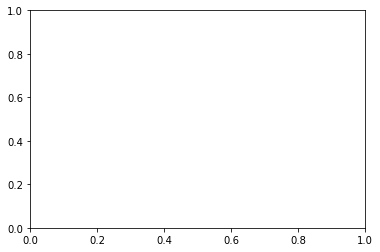

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
template_ws = r"D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow_enkf\flow1d_tmp"
posterior_par = pd.read_csv(os.path.join(template_ws, "flow1d.global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')


In [ ]:
## Try more iterations for 

In [ ]:
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['DA_SUBSET_SIZE'] = 10
pst.pestpp_options['ies_init_lam'] = [10]
pst.pestpp_options['ies_lambda_mults'] = [0.1, 1, 10]
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 5 # number of iterations
pst.write(os.path.abspath(pf.pst.filename), version=2)

In [ ]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)

In [ ]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')

In [ ]:
sys.path.append(r"..")
import rec_util 
import rec_util
ws = r"D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\new_od_flow_template"
fname = r"od_flow_template.rec"

fname = os.path.join(ws, fname)
rec = rec_util.RecFile(fname= os.path.join(new_d, template_ws+".rec"))

